   # <u>Data Challenge(AIRBNB & ZILLOW)</u>
   ###  Anirudh Bhanu Teja Addala 

#### <u> Problem Statement</u> :
- Identifying the Zip Codes in the New York City, where the investment in the two bedroom properties is most profitable.

# Assumptions
1. From the [ipropertymanagement](https://ipropertymanagement.com/airbnb-statistics/) website, we have gathered information                                    that Airbnb visitors stay on average __6.4__ nights at NYC. This data is useful in calculating the cleaning fee at each Airbnb stay.
2. Occupancy Rate across all the Zip Codes is considered as __75%__
3. The time value of money discount rate is 0% (i.e. $1 today is worth the same 100 years from now).
4. The investor will pay for the property in cash (i.e. no mortgage/interest rate will need to be accounted for).

## Necessary Libraries and Packages
- Data Manipultaion packages - **numpy, pandas**
- Data Visualization packages - **matplotlib, seaborn, plotly, pygal**
- Machine Learning libraries - **sklearn, pyramid, statsmodels**

In [1]:
#importing the libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
import ipywidgets as widgets
from pyramid.arima import auto_arima
import pygal
import statsmodels.api as sm
import itertools
from IPython.display import display, HTML
init_notebook_mode(connected=True) # helps in plotting the plotly graphs inside the Jupyter notebook
plt.style.use('fivethirtyeight')
import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

In [2]:
# Average_Stay is the value describing the stay of an average customer to Airbnb at NYC in a year (vary between 1-365)
Average_Stay = 6.4
#Panned_Date_of_Investment should be in the format of "YYYY-MM-DD"
Planned_Date_of_Investment = '2019-04-01'
# Occupancy_Factor is the occupancy percentage of a property in a year of 365 Days in the NYC
Occupancy_Factor = 0.75
# planned_city provides the details of where the client is intersted in investing
planned_city = 'New York'

## Exploratory Data Analysis of Airbnb Listings

In [3]:
Data = pd.read_csv(r'C:\Users\aniru\OneDrive\Desktop\Data_Challenge\listings.csv', low_memory=False)
print(Data.shape)

(40753, 95)


- The Airbnb data has **40753** observations and **95** features to analyze.
- We will look at the data and consider the important features necessary for our analysis

In [4]:
# this is used to display the entire table. using Data.head() doesn't render all the 95 columns
display(HTML(Data.head().to_html()))

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,notes,transit,access,interaction,house_rules,thumbnail_url,medium_url,picture_url,xl_picture_url,host_id,host_url,host_name,host_since,host_location,host_about,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_thumbnail_url,host_picture_url,host_neighbourhood,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,street,neighbourhood,neighbourhood_cleansed,neighbourhood_group_cleansed,city,state,zipcode,market,smart_location,country_code,country,latitude,longitude,is_location_exact,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,square_feet,price,weekly_price,monthly_price,security_deposit,cleaning_fee,guests_included,extra_people,minimum_nights,maximum_nights,calendar_updated,has_availability,availability_30,availability_60,availability_90,availability_365,calendar_last_scraped,number_of_reviews,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7949480,https://www.airbnb.com/rooms/7949480,20170502132028,2017-05-03,City Island Sanctuary relaxing BR & Bath w Par...,Come relax on City Island in our quiet guest r...,"On parle français et anglais, (lire Français c...",Come relax on City Island in our quiet guest r...,none,City Island is a unique sanctuary in New York ...,We are walkable to Pelham Park which is the la...,"On the island, you can walk to everything. A ...",Feel free to enjoy our large backyard in seaso...,We speak fluent French and English. We will b...,No extra guests or visitors who are not in the...,https://a0.muscache.com/im/pictures/001d1cb0-6...,https://a0.muscache.com/im/pictures/001d1cb0-6...,https://a0.muscache.com/im/pictures/001d1cb0-6...,https://a0.muscache.com/im/pictures/001d1cb0-6...,119445,https://www.airbnb.com/users/show/119445,Linda & Didier,2010-05-06,"New York, New York, United States","I am a designer, former instructor at a design...",within an hour,100%,NaN,t,https://a0.muscache.com/im/pictures/2de30fe4-b...,https://a0.muscache.com/im/pictures/2de30fe4-b...,City Island,1.0,1.0,"['email', 'phone', 'reviews', 'jumio']",t,t,"City Island, Bronx, NY 10464, United States",City Island,City Island,Bronx,Bronx,NY,10464,New York,"Bronx, NY",US,United States,40.852054,-73.788680,t,House,Private room,2,1.0,1.0,1.0,Real Bed,"{""Cable TV"",""Wireless Internet"",""Air condition...",NaN,$99.00,NaN,NaN,$100.00,NaN,1,$20.00,1,7,yesterday,NaN,24,54,80,170,2017-05-03,25,2016-01-18,2017-04-23,100.0,10.0,10.0,10.0,10.0,10.0,10.0,f,NaN,NaN,f,moderate,t,t,1,1.59
1,16042478,https://www.airbnb.com/rooms/16042478,20170502132028,2017-05-04,WATERFRONT STUDIO APARTMENT,My place is close to Sea Shore. You’ll love my...,(URL HIDDEN),My place is close to Sea Shore. You’ll love my...,none,(URL HIDDEN),"Fine sea food restaurant, bars and night clubs...",NaN,"public transport from Grand Central, NYC or fr...",NaN,NaN,https://a0.muscache.com/im/pictures/bb5bc3c4-3...,https://a0.muscache.com/im/pictures/bb5bc3c4-3...,https://a0.muscache.com/im/pictures/bb5bc3c4-3...,https://a0.muscache.com/im/pictures/bb5bc3c4-3...,9117975,https://www.airbnb.com/users/show/9117975,Collins,2013-09-29,"New York, New York, United States",I am married with 3 children and 2 grandkid. ...,a few days or more,0%,NaN,f,https://a0.muscache.com/im/users/9117975/profi...,https://a0.muscache.com/im/users/9117975/profi...,City Island,1.0,1.0,"['phone', 'facebook']",t,f,"City Island, Bronx, NY 10464, United States",City Island,City Island,Bronx,Bronx,NY,10464,New York,"Bronx, NY",US,United States,40.853491,-73

- It is observed that ***zipcode, bedrooms, price, cleaning_fee, latitude, longitude, neighbourhood_group_cleansed, property_type, room_type, availability_30, availability_365, host_response_rate, host_acceptance_rate*** are essential in determing the investment options in NYC.
- There are other features like *accommodates, transit, reviews, amenities* which can be used for providing a quality of stay after the property is owned. But, it doesn't provide much contribution for initial analysis.

In [5]:
#Selecting the required columns
Required_Data = Data.loc[:,['zipcode', 'bedrooms', 'price', 'cleaning_fee','latitude','longitude',
                            'neighbourhood_group_cleansed','property_type', 'room_type', 'availability_30', 
                            'availability_365','host_response_rate', 'host_acceptance_rate']]

As we are interested in the Two bedroom properties in the NYC, let's have a look at the feature, "**bedrooms**", in the Airbnb data and find the missing values. 

In [6]:
print("""The number of observations where the details for
the number of bedrooms is not given are: {}""".format(Required_Data.bedrooms.isnull().sum()))

The number of observations where the details for
the number of bedrooms is not given are: 69


As **69** is a very small value in consideration to the 40K observations which is less than 1%. Imputation will not affect the results of our analysis.

In [7]:
#selecting only 2 bedrooms listings.
Required_Data_2bed=Required_Data.loc[Required_Data['bedrooms']==2]
print("The number of 2 bedroom residencies in the NewYork state is:{}".format(len(Required_Data_2bed)))

The number of 2 bedroom residencies in the NewYork state is:4894


Let's look at the distribution of residencies by each neighbourhood

In [8]:
neighbourhood_groups=Required_Data_2bed.loc[:,"neighbourhood_group_cleansed"].value_counts()
base_html = """
<!DOCTYPE html>
<html>
  <head>
  <script type="text/javascript" src="http://kozea.github.com/pygal.js/javascripts/svg.jquery.js"></script>
  <script type="text/javascript" src="https://kozea.github.io/pygal.js/2.0.x/pygal-tooltips.min.js""></script>
  </head>
  <body>
    <figure>
      {rendered_chart}
    </figure>
  </body>
</html>
"""

def galplot(chart):
    rendered_chart = chart.render(is_unicode=True)
    plot_html = base_html.format(rendered_chart=rendered_chart)
    display(HTML(plot_html))

bar_chart = pygal.Bar(spacing=50, height=400)
bar_chart.title = "Residencies available in each Neighbourhood"
#bar_chart.x_labels = list(neighbourhood_groups.index)
for i in range(len(neighbourhood_groups)):
    bar_chart.add(list(neighbourhood_groups.index)[i], list(neighbourhood_groups.values)[i])
galplot(bar_chart)

- Now, as we have analyzed the neighbourhood data, we need to understand how the rental rates of each property pans out to be. 
- For our ease of analysis, lets convert the data to numeric format and categorical format for different features.
- we will define a function, **"clean_string"**,  to convert the prices columns to numeric data.

In [9]:
def clean_string(row):
    row =str(row)
    cleaned_row = row.replace("$", "").replace(",", "").replace(" ", "")
    return (float(cleaned_row))
Required_Data_2bed.loc[:,['price','cleaning_fee']]=Required_Data_2bed.loc[:,['price','cleaning_fee']].applymap(clean_string)

**Zipcode** is our primary variable and we need to verify if all the values are provided properly. If not, we need to either clean the zipcode value, eliminating the unnecessary components **('-',' ' or other symbols)** or impute them if missing(**'Nan'**)

In [10]:
Required_Data_2bed[Required_Data_2bed.loc[:,'zipcode'].apply(lambda x: True if len(str(x))>5 else False )]

,zipcode,bedrooms,price,cleaning_fee,latitude,longitude,neighbourhood_group_cleansed,property_type,room_type,availability_30,availability_365,host_response_rate,host_acceptance_rate
4308,11426-1175,2.0,140.0,NaN,40.725633,-73.726984,Queens,House,Entire home/apt,30,365,0%,NaN
13781,10003-8623,2.0,215.0,95.0,40.724109,-73.990818,Manhattan,Apartment,Entire home/apt,3,173,100%,NaN


- As we have found there are 2 observations whose zipcode is longer than the standard length of 5. We will consider only the first five characters as zipcode in our analysis.

In [11]:
Required_Data_2bed.loc[:,'zipcode'] =Required_Data_2bed.loc[:,'zipcode'].apply(lambda x: str(x)[0:5] if len(str(x))>5 else x )

- Visualizing the missing values will provide better understanding of the features to consider for finding the bst zipcode to invest in.

In [12]:
#Required_Data_2bed.loc[:,['availability_30','availability_365']]=Required_Data_2bed.loc[:,['availability_30','availability_365']].replace({0:np.nan})
missing_values_data =dict(Required_Data_2bed.isnull().sum())
missing_values_data ={k:v for k,v in missing_values_data.items() if v>0 }

In [13]:

bar_data =[go.Bar(
    x=list(missing_values_data.keys()),
    y=list(missing_values_data.values()),
    opacity=0.8
    
)]
layout = go.Layout(
    autosize=True,
    width=600,
    height=500,
    title='Missing Values of Airbnb data',
)
fig = go.Figure(data=bar_data, layout=layout)
iplot(fig)

- By **hovering** over the above bar graph it can be understood that there are **62** zipcodes whose data is missing. We will impute the zipcode data usig the ***K-Nearest Neighbour algorithm*** from ***sklearn***
- The cleaning fee is also missing for **966** observations
- The **host_response_rate** is having **1308** missing observations. This can be excluded from our analysis as it will not give any idea on the investment cost of a zipcode. This is useful when the property is put used for hosting as under Airbnb.
- The **host_acceptance_rate** is completely missing. So, we will not be using this in our analysis.

In [14]:
Zip_Code_Data =Required_Data_2bed.loc[~Required_Data_2bed.zipcode.isnull(),['latitude','longitude','neighbourhood_group_cleansed','zipcode']].reset_index(drop=True)
Zip_Code_Data[['neighbourhood_group_cleansed']]=Zip_Code_Data[['neighbourhood_group_cleansed']].astype('category')
Zip_Code_Data.head()

,latitude,longitude,neighbourhood_group_cleansed,zipcode
0,40.857532,-73.866055,Bronx,10462
1,40.870541,-73.846807,Bronx,10469
2,40.771715,-73.917688,Queens,11102
3,40.779373,-73.915532,Queens,11102
4,40.780802,-73.910246,Queens,11105


We will be using the **latitude, longitude & neighbourhood** for determining zipcode of the missing observations. These features will be sufficient as they determine the geographical locations accurately for predicting the zipcode values.

We will be using the KNN cross validation for increasing the accuracy of our model and eliminate the sampling error.

In [15]:
# create design matrix X and target vector y
X = np.array(Zip_Code_Data[['latitude','longitude']])
y = np.array(Zip_Code_Data['zipcode'])
# split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0, random_state=123)

In [16]:
# creating odd list of K for KNN
myList = [i for i in range(1,25) if i%2==1]
# empty list that will hold cv scores
cv_scores = []
# perform 5-fold cross validation
for k in myList:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(scores.mean())


The optimal number of neighbors is 3


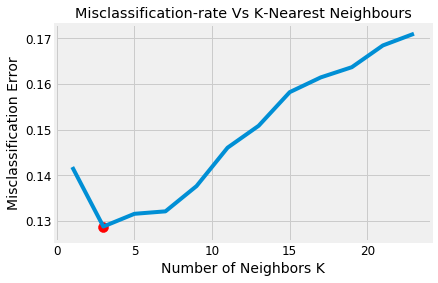

In [17]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores]
MSE.index(min(MSE))
# determining best k
optimal_k = myList[MSE.index(min(MSE))]
print ("The optimal number of neighbors is %d" % optimal_k)

# plot misclassification error vs k
plt.plot(myList, MSE)
plt.scatter(optimal_k,MSE[MSE.index(min(MSE))], s=100, c='r')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.title('Misclassification-rate Vs K-Nearest Neighbours')
plt.show()

- The above graph gives the lowest misclassification error at K=3, in KNN classification.(**Given by the red circle in the above graph**)
- So we will be using the above parameters to fill the missing zipcodes using KNN algorithm

In [18]:
Missing_Zip_Codes=Required_Data_2bed.loc[Required_Data_2bed.zipcode.isnull(),['latitude','longitude','neighbourhood_group_cleansed','zipcode']]

In [19]:
# instantiate learning model (k = 3)
knn = KNeighborsClassifier(n_neighbors=3)
# fitting the model
knn.fit(X_train, y_train)
X_test=np.array(Missing_Zip_Codes[['latitude','longitude']])
# predict the response
pred = knn.predict(X_test)

In [20]:
Missing_Zip_Codes['zipcode']=pred

In [21]:
a=list(Missing_Zip_Codes.index)

In [22]:
#Required_Data_2bed.loc[Required_Data_2bed['zipcode'].isnull()]
Required_Data_2bed.loc[a,'zipcode']=Missing_Zip_Codes.loc[a,'zipcode']

- The predicted values from the model are filled to the main data set **"Required_Data_2bed"**

In [23]:
Required_Data_2bed[Required_Data_2bed.select_dtypes(['object']).columns] = Required_Data_2bed.select_dtypes(['object']).apply(lambda x: x.astype('category'))

The ***cleaning_fee*** is having around **966** missing observations. We shall use ***RandomForestRegressor*** from ***sklearn*** to fill the missing values. We prefer ***RandomForest*** approach than ***KNN*** for imputation because this perform efficiently with data having a combination of *categorical* and *numerical* data, where as for KNN, the predictor variables have to be numerical.

In [24]:
cols = [col for col in Required_Data.columns if col not in ('host_response_rate','host_acceptance_rate','cleaning_fee','neighbourhood_group_cleansed',
                                                            'property_type', 'room_type')]
X_train =Required_Data_2bed.loc[~Required_Data_2bed.cleaning_fee.isnull(), cols ]
X_test =Required_Data_2bed.loc[Required_Data_2bed.cleaning_fee.isnull(), cols ]
y_train = Required_Data_2bed.loc[~Required_Data_2bed.cleaning_fee.isnull(), 'cleaning_fee']

In [25]:
rf = RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=10,
           max_features='sqrt', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=None,
           oob_score=False, random_state=0, verbose=0, warm_start=False)
rf.fit(X_train, y_train)
pred=rf.predict(X_test)

In [26]:
Required_Data_2bed.loc[Required_Data_2bed.cleaning_fee.isnull(), 'cleaning_fee']=pred

In [27]:
cols=[col for col in Required_Data_2bed.columns if col not in ('host_response_rate','host_acceptance_rate','bedrooms')]
Required_Data_2bed = Required_Data_2bed.loc[:,cols].copy()

- As all the missing values of necessary features are completely filled, we will now examine the price distribution of various neighbourhoods in the given data.

In [28]:
Required_Data_2bed.neighbourhood_group_cleansed.unique()

[Bronx, Queens, Staten Island, Brooklyn, Manhattan]
Categories (5, object): [Bronx, Queens, Staten Island, Brooklyn, Manhattan]

In [29]:
#%matplotlib inline
out1 = widgets.Output()
out2 = widgets.Output()
out3 = widgets.Output()
out4 = widgets.Output()
out5 = widgets.Output()

Bronx = Required_Data_2bed.loc[Required_Data_2bed.neighbourhood_group_cleansed=='Bronx','price']
Queens = Required_Data_2bed.loc[Required_Data_2bed.neighbourhood_group_cleansed=='Queens','price']
Staten_Island = Required_Data_2bed.loc[Required_Data_2bed.neighbourhood_group_cleansed=='Staten Island','price']
Brooklyn = Required_Data_2bed.loc[Required_Data_2bed.neighbourhood_group_cleansed=='Brooklyn','price']
Manhattan = Required_Data_2bed.loc[Required_Data_2bed.neighbourhood_group_cleansed=='Manhattan','price']

tab = widgets.Tab(children = [out1, out2, out3,out4, out5])
tab.set_title(0, 'Bronx')
tab.set_title(1, 'Queens')
tab.set_title(2, 'Staten Island')
tab.set_title(3, 'Brooklyn')
tab.set_title(4, 'Manhattan')
display(tab)
a4_dims = (8, 8)
with out1:
    fig, axes = plt.subplots(figsize=a4_dims)
    sns.distplot(Bronx, color='darkblue')
    plt.title('The price distribution of Bronx',size=18)
    plt.show()

with out2:
    fig, axes = plt.subplots(figsize=a4_dims)
    sns.distplot(Queens,color='darkgreen')
    plt.title('The price distribution of Queens',size=18)
    plt.show()
with out3:
    fig, axes = plt.subplots(figsize=a4_dims)
    sns.distplot(Staten_Island, color='indigo')
    plt.title('The price distribution of Staten_Island',size=18)
    plt.show()    
with out4:
    fig, axes = plt.subplots(figsize=a4_dims)
    sns.distplot(Brooklyn, color='B')
    plt.title('The price distribution of Brooklyn',size=18)
    plt.show()   
with out5:
    fig, axes = plt.subplots(figsize=a4_dims)
    sns.distplot(Manhattan, color='darkred')
    plt.title('The price distribution of Manhattan',size=18)
    plt.show()

In [30]:
a =list(Required_Data_2bed['neighbourhood_group_cleansed'].unique())
data=[]

for i in range(len(a)):
    data.append(go.Histogram(
    x=list(Required_Data_2bed.loc[Required_Data_2bed['neighbourhood_group_cleansed']==a[i],'price']),
    opacity=0.8,
    histnorm='probability',
    name=a[i]
))
layout = go.Layout(
     xaxis=dict(
        range=[0, 1000]
    ),
    autosize=True,
    width=1000,
    height=500,
    title='Price distribution of different neighbourhoods in NY ',
)
fig = go.Figure(data=list(data), layout=layout)
iplot(fig)

In [31]:
Required_Data_2bed.groupby('neighbourhood_group_cleansed')['price', 'cleaning_fee'].mean()

,price,cleaning_fee
neighbourhood_group_cleansed,,
Bronx,121.169811,65.917224
Brooklyn,176.447332,77.778723
Manhattan,300.044003,94.933543
Queens,147.423077,68.093919
Staten Island,118.766667,63.770717


- The above graph gives the distribution of price for each neighbourhood. From the graphs we can assume a nromal distribution around different means. 
- The mean price of each neighbourhood is also shown in the above table.
- It can be observed that the manhattan area has highest revenues in rentals  by **1.5 to 3** times when compared with all other neighbourhoods

## Revenue analysis from properties
- **Yearly revenue from rentals is calculated as** $$Revenue_r = price_d*(OccupancyFactor)*365 $$
    - *$Revenue_r$ = Revenue obtained through rent yearly*
    - *$price_d$ = price for one day/night*
    - *$OccupancyFactor$ = How many days is the property occupied by visitors/365*
- **Yearly revenue from cleaning is calculated as** $$Revenue_C = price_C*1/Stay_A*OccupancyFactor*365 $$
    - *$Revenue_C$ = Revenue obtained through cleaning in a year*
    - *$price_C$ = cleaning price charged towards customer for his stay(charged only once during entire stay)*
    - *$Stay_A$ = Average period of stay by the customer. In NYC it is assumed to be __6.4__*
    
- **Total yearly revenue from property is calculated as** $$Revenue_T = Revenue_r +Revenue_C$$

In [32]:
clean_factor=1/Average_Stay
Required_Data_2bed.loc[:,'Revenue_rent'] = Required_Data_2bed.loc[:,'price'].apply(lambda x: x*Occupancy_Factor*365)
Required_Data_2bed.loc[:,'Revenue_clean'] = Required_Data_2bed.loc[:,'cleaning_fee'].apply(lambda x: x*clean_factor*Occupancy_Factor*365)
Required_Data_2bed.loc[:,'Revenue_total'] = Required_Data_2bed.loc[:,'Revenue_rent']+Required_Data_2bed.loc[:,'Revenue_clean']

- Let's __count__ the *<u>number of listings</u>* by each zipcode for ease of analysis and append the values to the dataframe

In [33]:
Revenue_yearly = Required_Data_2bed.groupby(['zipcode', 'neighbourhood_group_cleansed'], as_index=False).mean()[['zipcode','Revenue_rent',
                                                        'Revenue_clean','Revenue_total','neighbourhood_group_cleansed']].dropna()
listings_zip_series=Required_Data_2bed['zipcode'].value_counts()
listings_per_zip =pd.DataFrame({'zipcode':listings_zip_series.index, 'num_listings':listings_zip_series.values})
Revenue_Data = pd.merge(Revenue_yearly,listings_per_zip, on ='zipcode', how='inner')

In [34]:
display(HTML(Revenue_Data.head().to_html()))

,zipcode,Revenue_rent,Revenue_clean,Revenue_total,neighbourhood_group_cleansed,num_listings
0,07310,18341.250000,2905.538352,21246.788352,Manhattan,1
1,10001,114500.825893,5299.047415,119799.873308,Manhattan,56
2,10002,90733.632353,4038.924484,94772.556837,Manhattan,170
3,10003,85525.583333,4061.226309,89586.809643,Manhattan,135
4,10004,96688.500000,4520.562738,101209.062738,Manhattan,10


In [35]:
a =list(Required_Data_2bed['neighbourhood_group_cleansed'].unique())
data=[]

for i in range(len(a)):
    data.append(go.Scatter(
    x=['`'+str(j) for j in list(Revenue_Data.loc[Revenue_Data['neighbourhood_group_cleansed']==a[i],'zipcode'])],
    y=list(Revenue_Data.loc[Revenue_Data['neighbourhood_group_cleansed']==a[i],'Revenue_total']),
    opacity=0.8,
    mode='markers',
    name=a[i]
))
layout = go.Layout(
    autosize=True,
    title='Revenue distribution across different neighbourhoods in NY ',
)
fig = go.Figure(data=list(data), layout=layout)
iplot(fig)

- The above plot gives the **Revenue distribution** across different neighbourhood. **Hover** over the points in the above plot to know the exact revenue generated and the zipcode.
- Now, as we have gathered the Revenue generation across different neighbourhood, the price of the property at those zipcodes is necessary to determine the best investment property.
- We will utilize the ***ZILLOW*** house pricing data for further analysis.

## <u>Analysis of ZILLOW Data</u>


In [36]:
Zillow_Data = pd.read_csv(r"C:\Users\aniru\OneDrive\Desktop\Data_Challenge\airbnb-zillow-data-challenge-master\Zip_Zhvi_2bedroom.csv", low_memory = False)
display(HTML(Zillow_Data.head().to_html()))
print(Zillow_Data.shape)

,RegionID,RegionName,City,State,Metro,CountyName,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,1996-11,1996-12,1997-01,1997-02,1997-03,1997-04,1997-05,1997-06,1997-07,1997-08,1997-09,1997-10,1997-11,1997-12,1998-01,1998-02,1998-03,1998-04,1998-05,1998-06,1998-07,1998-08,1998-09,1998-10,1998-11,1998-12,1999-01,1999-02,1999-03,1999-04,1999-05,1999-06,1999-07,1999-08,1999-09,1999-10,1999-11,1999-12,2000-01,2000-02,2000-03,2000-04,2000-05,2000-06,2000-07,2000-08,2000-09,2000-10,2000-11,2000-12,2001-01,2001-02,2001-03,2001-04,2001-05,2001-06,2001-07,2001-08,2001-09,2001-10,2001-11,2001-12,2002-01,2002-02,2002-03,2002-04,2002-05,2002-06,2002-07,2002-08,2002-09,2002-10,2002-11,2002-12,2003-01,2003-02,2003-03,2003-04,2003-05,2003-06,2003-07,2003-08,2003-09,2003-10,2003-11,2003-12,2004-01,2004-02,2004-03,2004-04,2004-05,2004-06,2004-07,2004-08,2004-09,2004-10,2004-11,2004-12,2005-01,2005-02,2005-03,2005-04,2005-05,2005-06,2005-07,2005-08,2005-09,2005-10,2005-11,2005-12,2006-01,2006-02,2006-03,2006-04,2006-05,2006-06,2006-07,2006-08,2006-09,2006-10,2006-11,2006-12,2007-01,2007-02,2007-03,2007-04,2007-05,2007-06,2007-07,2007-08,2007-09,2007-10,2007-11,2007-12,2008-01,2008-02,2008-03,2008-04,2008-05,2008-06,2008-07,2008-08,2008-09,2008-10,2008-11,2008-12,2009-01,2009-02,2009-03,2009-04,2009-05,2009-06,2009-07,2009-08,2009-09,2009-10,2009-11,2009-12,2010-01,2010-02,2010-03,2010-04,2010-05,2010-06,2010-07,2010-08,2010-09,2010-10,2010-11,2010-12,2011-01,2011-02,2011-03,2011-04,2011-05,2011-06,2011-07,2011-08,2011-09,2011-10,2011-11,2011-12,2012-01,2012-02,2012-03,2012-04,2012-05,2012-06,2012-07,2012-08,2012-09,2012-10,2012-11,2012-12,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,2013-11,2013-12,2014-01,2014-02,2014-03,2014-04,2014-05,2014-06,2014-07,2014-08,2014-09,2014-10,2014-11,2014-12,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,2015-11,2015-12,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,61639,10025,New York,NY,New York,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,798600.0,798800.0,801500.0,804600.0,814900.0,828300.0,835700.0,849300.0,858100.0,854000.0,834800.0,821700.0,830300.0,853700.0,868300.0,875200.0,882200.0,892400.0,905000.0,924000.0,934400.0,932100.0,927500.0,923600.0,907900.0,890900.0,883400.0,896100.0,923900.0,952900.0,964600.0,972500.0,973800.0,973400.0,966500.0,966800.0,967100.0,974800.0,976800.0,976100.0,973700.0,974500.0,973200.0,966400.0,950400.0,933300.0,920900.0,909400.0,891400.0,873300.0,858800.0,850200.0,842800.0,834000.0,828800.0,821400.0,813900.0,813300.0,821500.0,831700.0,845100.0,854500.0,858900.0,859200.0,863500.0,876000.0,886100.0,890000.0,894200.0,901800.0,909500.0,913300.0,907400.0,900000.0,897700.0,896300.0,892300.0,890400.0,888600.0,891700.0,899500.0,904400.0,908200.0,914000.0,915100.0,912300.0,914000.0,921100.0,923300.0,917300.0,915000.0,922800.0,929100.0,937700.0,955700.0,974200.0,995500.0,1019500.0,1035100.0,1054900.0,1079900,1092600,1103500,1118800,1139300,1154600,1144100,1120300,1125500,1136000,1135100,1130000,1138200,1153700,1174800,1185400,1188400,1189700,1193700,1199900,1201400,1202600,1214200,1235200,1258000,1287700,1307200,1313900,1317100,1327400,1338800.0,1350400.0,1356600.0,1358500.0,1364000,1373300,1382600,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
1,84654,60657,Chicago,IL,Chicago,Cook,2,167700.0,166400.0,166700.0,167200.0,166900.0,166900.0,168000.0,170100.0,171700.0,173000.0,17460

(8946, 262)


- The data has **8946** observations and **262** columns
- We will filter the __New York__ data which is where we are interested in investing.

In [37]:
Zillow_temp = Zillow_Data[Zillow_Data['City']=='New York']
print(Zillow_temp.shape)

(25, 262)


In [38]:
Zillow_NY = Zillow_temp.T
Zillow_NY.columns = list(Zillow_NY.loc['RegionName',:].astype(str))

In [39]:
Zillow_NY = Zillow_NY.loc["1996-04":,:]
Zillow_NY.index = pd.DatetimeIndex(Zillow_NY.index).date
display(HTML(Zillow_NY.head().to_html()))

,10025,10023,10128,10011,10003,11201,11234,10314,11215,10028,10021,10014,10036,11434,10306,10312,10022,11217,10013,11231,10304,10305,10309,10308,10303
1996-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123100,NaN,NaN,NaN,NaN,NaN,NaN,138100,153000,NaN,NaN,NaN,NaN,117500,131900,129100,149600,99200
1996-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,124000,NaN,NaN,NaN,NaN,NaN,NaN,136900,149800,NaN,NaN,NaN,NaN,113700,131900,129200,148200,102000
1996-06-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123900,NaN,NaN,NaN,NaN,NaN,NaN,135900,146900,NaN,NaN,NaN,NaN,111200,131400,129000,146800,103900
1996-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,123300,NaN,NaN,NaN,NaN,NaN,NaN,134500,144800,NaN,NaN,NaN,NaN,111100,130800,129400,144800,105400
1996-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122900,NaN,NaN,NaN,NaN,NaN,NaN,132900,143000,NaN,NaN,NaN,NaN,110400,130200,130300,143100,106900


- As we can see the missing values of different zipcodes on different dates, let's visualize the missing data.

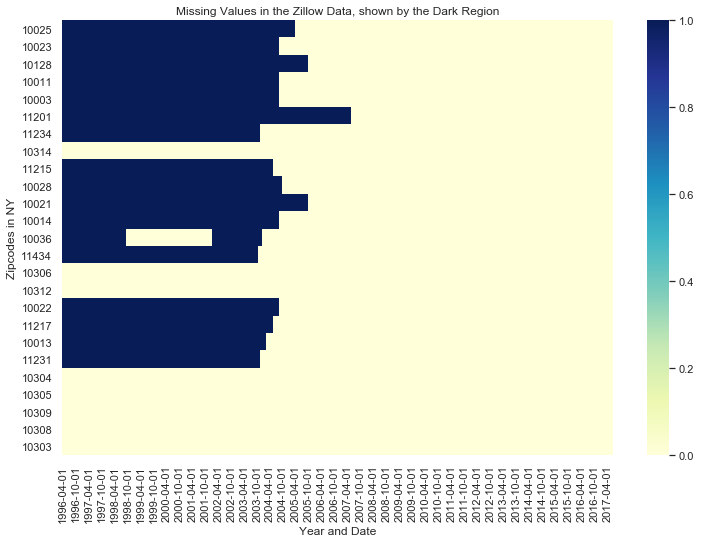

In [40]:
sns.set(rc={'figure.figsize':(11,8)})
plt.title("Missing Values in the Zillow Data, shown by the Dark Region")
sns.heatmap(Zillow_NY.T.isnull(), cbar=True, cmap="YlGnBu")
plt.ylabel("Zipcodes in NY")
plt.xlabel('Year and Date')
plt.show()

- As we can observe from the above heatmap that there is missing data until year **"2007"**.
- So, we will consider the data from **"2008"**.
- Though, there is financial crisis in the year of **2008** the pattern of the data is useful in predicting the behaviour of the data over time which is helpful in estimating the future cost of the property at the zipcode.

In [41]:
Zillow_NY_cleaned = Zillow_NY[Zillow_NY.loc[:,'11201'].notnull()]
data = []
for k,i in enumerate(list(Zillow_NY.columns)):
    data.append(go.Scatter(
        x=Zillow_NY_cleaned.index,
        y=Zillow_NY_cleaned.loc[:,i],
        mode='lines',
        name=i
    ))
layout = go.Layout(
    autosize=True,
    title='Price distribution of different Zipcodes in NY city',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

- It can be observed from the above plot that the prices are increasing overtime. **Hover** over the lines to see the price increase.
- The data is available only until data "2017-06-01".
- As, we are calculating the investment on properties in the year __2019__, we need to forecast the present prices based on the existing data by using the **Time Series Analysis**
- As all the prices are increasing for all the zip codes in a similar way, we will evaluate the time series model on a single **Zip Code- 10014** and then generalize the model for the remaining zip codes.

### <u> Analysis on Zip-Code 10014 </u>
- We will visualize the data using function time-series decomposition that allows us to decompose our time series into three distinct components: **trend, seasonality, and noise**.


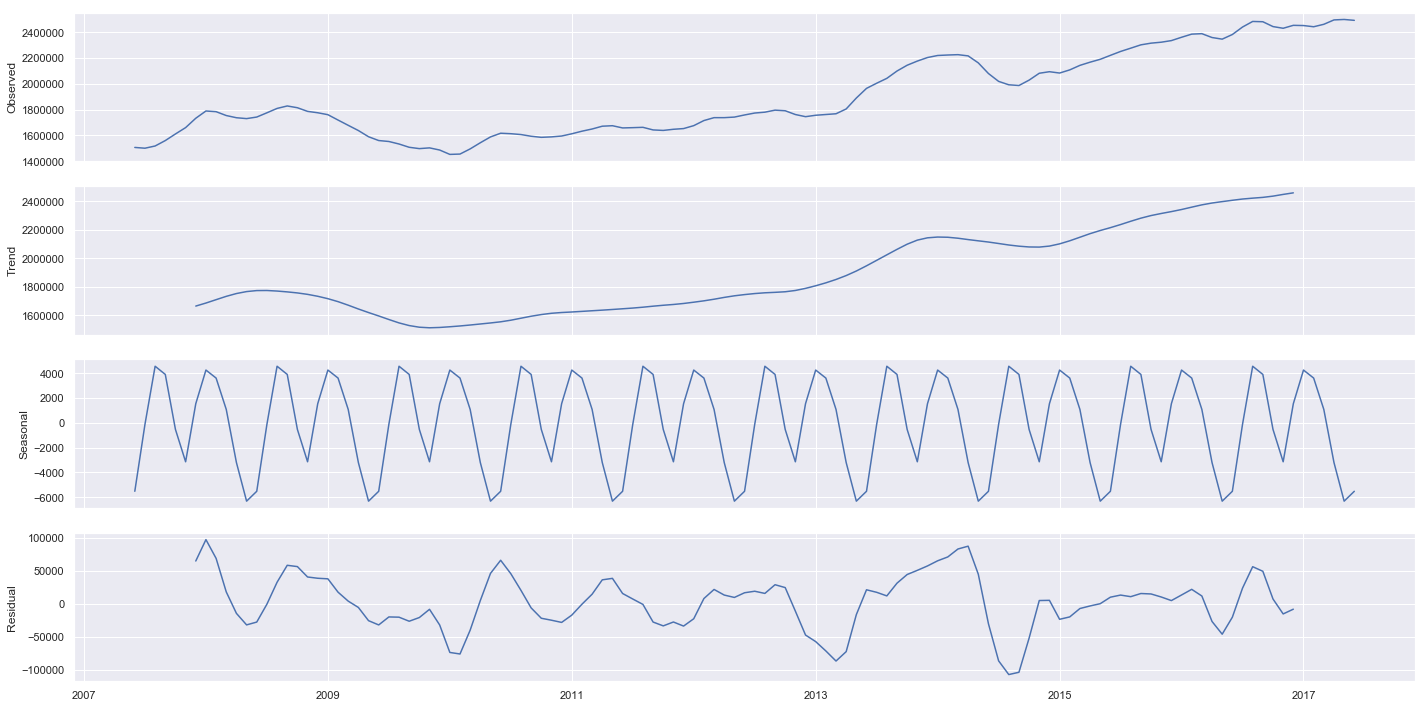

In [42]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10
y= pd.DataFrame(Zillow_NY_cleaned.loc[:,'10014'].astype('float'))
y.index=pd.DatetimeIndex(y.index)
decomposition = sm.tsa.seasonal_decompose(y, model='additive')
fig =decomposition.plot()
plt.show()

From the first look of seasonal decompose plot we can find the presence of seasonal component and an overall upward trend.It make sense to use a Seasonal ARIMA model. In order to do this we will need to choose p,d,q values for the ARIMA, and P,D,Q values for the Seasonal component.

For choosing the values we need to perform the "grid search" over multiple values of p,d,q and P,D,Q values using AIC performance criteria. The lowest value of AIC gives the better quality of model and parameters.


In [43]:
### p represents Seasonality, d represents Trend, q represents Noise
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


- Let's use the _"grid search"_  to find the best parameters suitabe to our model.

In [44]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:3816.476627068153
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:3372.3225738288843
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:2940.7577138716365
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:2616.3804891741884
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:2945.46276826583
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:2930.4067489112354
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:2645.00113501209
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:2611.814962143857
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:3701.1906551326338
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:3550.27130717147
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:2995.0704068900604
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:2581.110978972188
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:3664.872598812696
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:3549.0804779762548
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:2643.9242619158485
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:2516.29660061924
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:2794.990034117742
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:2502.493009777847
ARIMA(

C:\Users\aniru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:2505.2436488129315
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:2626.7771619247355
ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:2315.3157650734775
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:2518.0429630977364
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:2506.6657152824755
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:2309.8365748473075
ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:2308.79998153601
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:2674.377848787925


C:\Users\aniru\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2390.1001912453553
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:2649.863381641386
ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:2262.3935972373483
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:2422.911459199033
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2391.0593468291027
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:2286.1802588776586
ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:2264.3166823241945
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:2695.31272229695
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:2413.851801468122
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:2508.9250631798022
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:2222.1116641631324
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:2417.0795687895534
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:2415.661546961479
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:2217.394246342801
ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:2217.6343993501073
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:2653.8034656805453
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2347.936579446293
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:2475.1269916524825


- Thus we have obtained **SARIMAX(1, 1, 1)x(0, 1, 1, 12)** yielding the lowest AIC of ***2168***

In [45]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5792      0.092      6.309      0.000       0.399       0.759
ma.L1          0.7074      0.107      6.608      0.000       0.498       0.917
ma.S.L12      -0.0168      0.054     -0.313      0.754      -0.122       0.089
sigma2      5.691e+08   2.44e-11   2.33e+19      0.000    5.69e+08    5.69e+08


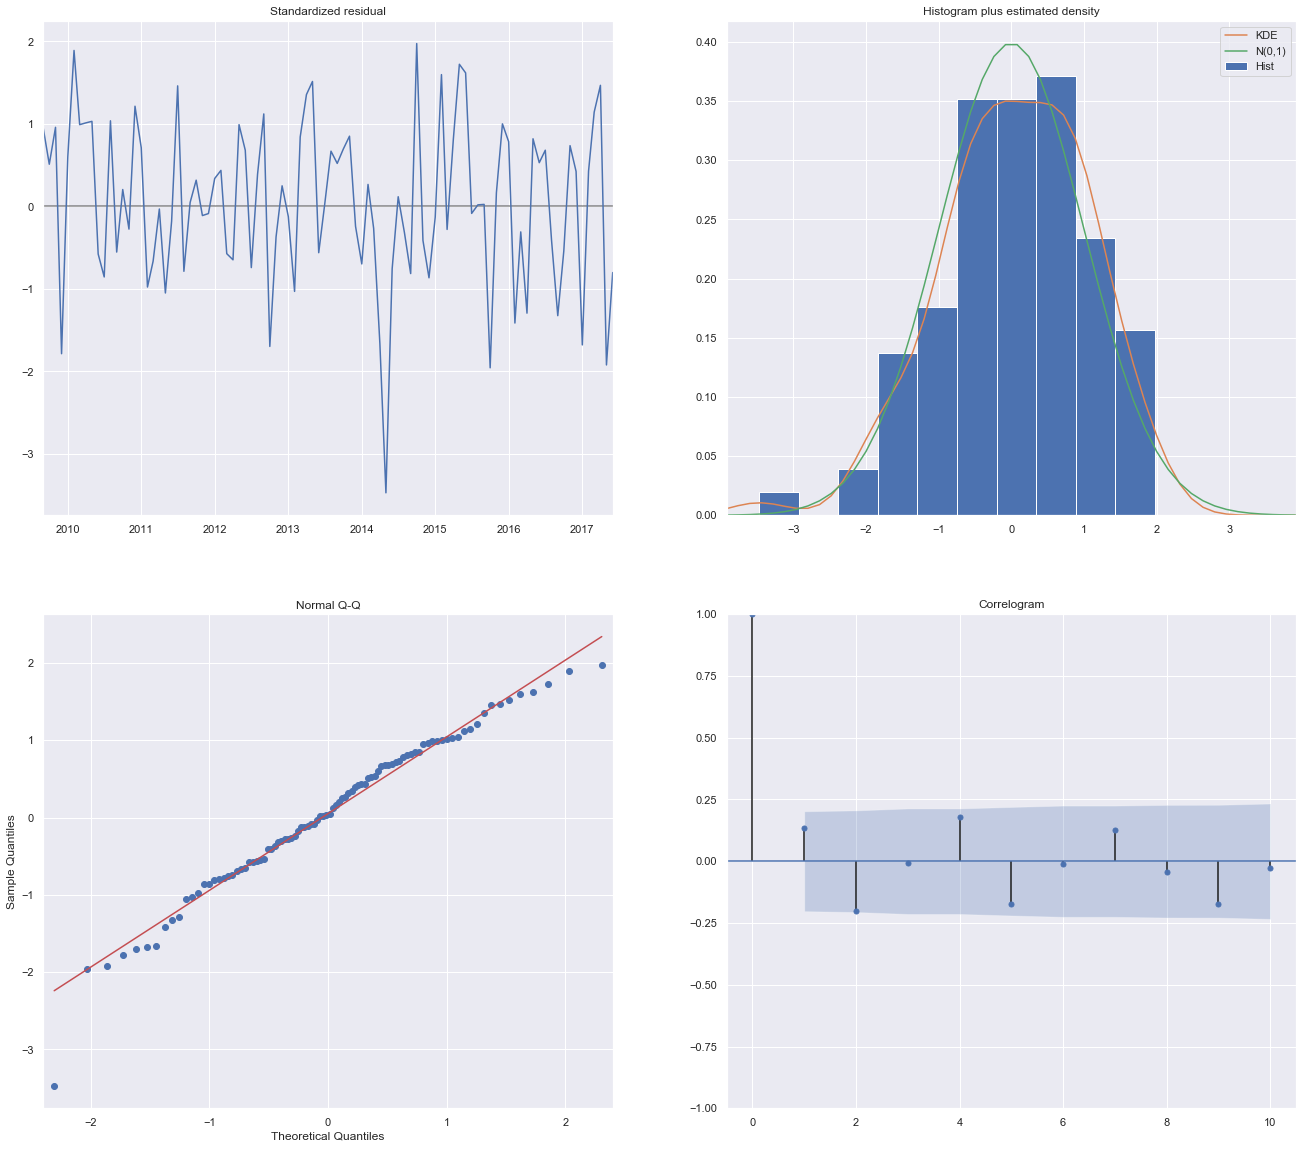

In [46]:
results.plot_diagnostics(figsize=(20, 20))
plt.show()

- Our model diagnostics suggests that out model is **nearly normally distributed**
- So we have acieved the **stationarity** of our data by using the Arima modelling. 
- Hence we can now forecast the prices of the zipcode **10014** for **2019** with reasonable accuracy.


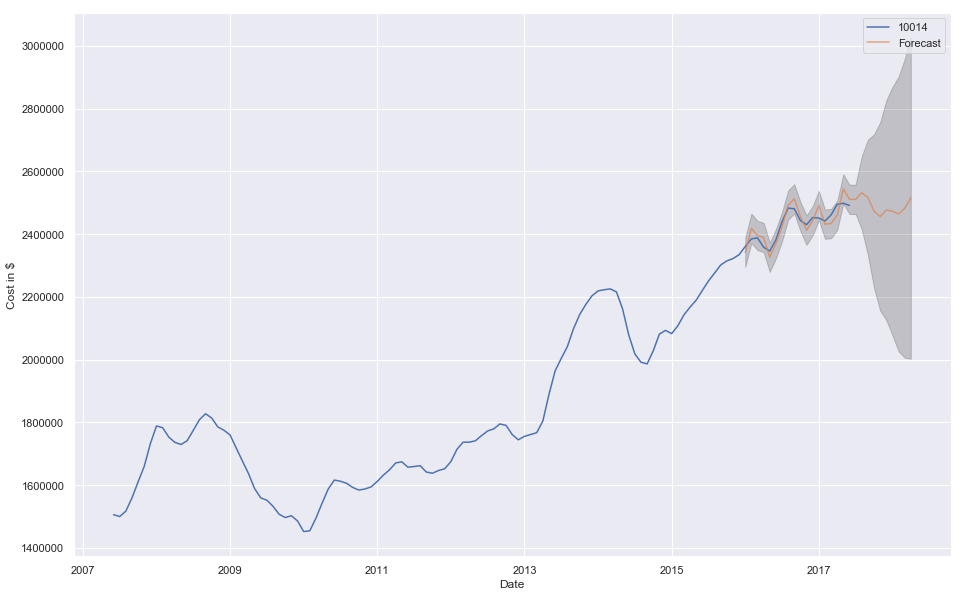

In [47]:
pred = results.get_prediction(start=pd.to_datetime('2016-01-01'),end=pd.to_datetime('2018-04-01'), dynamic=False)
pred_ci = pred.conf_int()

ax = y['2007':].plot()
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 10))

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Cost in $')
plt.legend()

plt.show()

- The line plot is showing the observed values compared to the rolling forecast predictions. Overall, our forecasts align with the true values very well, showing an upward trend starts from the beginning of the test prediction and captured the seasonality toward the end of the predictions.

In [48]:
y_forecasted = pred.predicted_mean
y_truth = y['2016-01-01':]
y_forecasted=pd.DataFrame(y_forecasted, columns=['Prediction'])
mse = ((y_forecasted.loc[:,'Prediction']-y_truth.loc[:,'10014']) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Mean Squared Error of our forecasts is 617223911.74
The Root Mean Squared Error of our forecasts is 24843.99


- The mean square error (MSE) is a measure of the quality of an estimator — it is always non-negative, and the smaller the MSE, the closer we are to finding the line of best fit. 
- Root Mean Square Error (RMSE) tells us that our model was able to forecast the average price of the two bed room property in the test set within $24843.99 of the actual price.

We will define a function ***"months_difference"*** to determine the number of months of data the model has to predict to determine the property cost(It will help us in estimating the cost of the property if bought on _"2019-04-01"_ or _"2019-06-01"_ or any other date).

In [49]:
def months_difference(date1, date2):
    date1 = datetime.strptime(date1, '%Y-%m-%d').date()
    date2 = datetime.strptime(date2, '%Y-%m-%d').date()
    if date1>date2:
        date1, date2 = date2, date1
    return ((date2.year-date1.year)*12 + (date2.month-date1.month))

- We will construct a function **forecasting_func**, to generate the prices of different zipcodes based on given dates.

In [50]:
def forecasting_func(Data, city, forecast_date):
    Data_temp = Data[Data['City']==city]
    Data_city = Data_temp.T
    Data_city.columns = list(Data_city.loc['RegionName',:].astype(str))
    Data_city = Data_city.loc["1996-04":,:]
    Data_city.index = pd.DatetimeIndex(Data_city.index).date
    Data_city = Data_city.dropna()
    date1 = str(Data_city.index[-1])
    no_months = months_difference(date1, forecast_date)
    listings_cost = []
    zip_codes = []
    for col1 in Data_city.columns:
        y= pd.DataFrame(Data_city.loc[:,col1].astype('float'))
        y.index=pd.DatetimeIndex(y.index)
        stepwise_model = auto_arima(y, start_p=0, start_q=0,
                               max_p=3, max_q=3, m=12,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=False,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
        stepwise_model.fit(y)
        forecasted_price =stepwise_model.predict(n_periods=no_months)[-1]
        zip_codes.append(col1)
        listings_cost.append(forecasted_price)
    return (pd.DataFrame({'zipcode':zip_codes, 'Predicted_Cost':listings_cost}))

In [51]:
Forecasted_Data = forecasting_func(Data=Zillow_Data, city='New York', forecast_date= Planned_Date_of_Investment)

In [52]:
Forecasted_Data.head()

,zipcode,Predicted_Cost
0,10025,1.478278e+06
1,10023,2.411668e+06
2,10128,2.192507e+06
3,10011,2.916506e+06
4,10003,2.489797e+06


Now, we will define a function **"Investment_Return_Fun"** which will merge the revenue generated per year from the NY listings with the  predicted prices from the Zillow data and helps in calculating key parameters like ROI and Break Even period for different Zipcodes.

This function is build so that the user can search the zipcodes even by considering the minimum and maximum number of listings available at the zipcode.

In [53]:
def Investment_Return_Fun(Target_Data, Price_Table,min_listings=1, max_listings=9999):
    Data= pd.merge(Target_Data, Price_Table, on='zipcode', how='inner')
    Data.loc[:,'Return_By_Rent']= (Data.loc[:,'Revenue_rent']/Data.loc[:,'Predicted_Cost'])*100
    Data.loc[:, 'Breakeven_Years']= (Data.loc[:,'Predicted_Cost']/Data.loc[:,'Revenue_total']).astype('int')
    Data.loc[:,'Return_Total']= (Data.loc[:,'Revenue_total']/Data.loc[:,'Predicted_Cost'])*100
    Data.rename(columns={'neighbourhood_group_cleansed':'neighbourhood'}, inplace= True)
    return (Data[(Data['num_listings']>=min_listings) & (Data['num_listings']<=max_listings)])
    
    

Now, let's visualize the Revenue and ROI of each zipcode with any number of listings.

In [54]:
Revenue_Margin_Data = Investment_Return_Fun(Revenue_Data, Forecasted_Data,min_listings=1, max_listings=500)
Revenue_Margin_Data.sort_values(['Revenue_rent'], ascending=False,inplace=True)
zipcode=['`'+str(z) for z in Revenue_Margin_Data.zipcode]
trace1= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Revenue_rent,
    text=Revenue_Margin_Data.neighbourhood,
    name ='Rent')
trace2= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Revenue_clean,
    name='Clean')
data=[trace1, trace2]
layout = go.Layout(
    autosize=True,
    barmode='stack',
    title='Revenue across different zipcodes of NY',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [55]:
#Revenue_Margin_Data = Investment_Return_Fun(Revenue_Data, Forecasted_Data,min_listings=1, max_listings=500)
Revenue_Margin_Data.sort_values(['Return_Total'], ascending=False,inplace=True)
zipcode=['`'+str(z) for z in Revenue_Margin_Data.zipcode]
trace1= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Return_Total,
    text=Revenue_Margin_Data.neighbourhood,
    marker=dict(
        color='rgba(100,100,40, 0.8)',
        line=dict(
            color='rgba(255,128,0)',
            width=1.5,
        )),
    name ='ROI')
data=[trace1]
layout = go.Layout(
    autosize=True,
    barmode='stack',
    title='ROI across different zipcodes of NY',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


We can observe that the properties under **zip code 10312** has the highest ROI of **14.67**

Now, Let's look at the zipcodes which are offering more than 30 properties.

In [56]:
Revenue_Margin_Data = Investment_Return_Fun(Revenue_Data, Forecasted_Data,min_listings=30, max_listings=500)
Revenue_Margin_Data.sort_values(['Revenue_rent'], ascending=False,inplace=True)
zipcode=['`'+str(z) for z in Revenue_Margin_Data.zipcode]
trace1= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Revenue_rent,
    text=Revenue_Margin_Data.neighbourhood,
    name ='Rent')
trace2= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Revenue_clean,
    name='Clean')
data=[trace1, trace2]
layout = go.Layout(
    autosize=True,
    barmode='stack',
    title='Revenue across different zipcodes of NY with listings>30',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


In [57]:
Revenue_Margin_Data.sort_values(['Return_Total'], ascending=False,inplace=True)
zipcode=['`'+str(z) for z in Revenue_Margin_Data.zipcode]
trace1= go.Bar(
    x=zipcode,
    y=Revenue_Margin_Data.Return_Total,
    text=Revenue_Margin_Data.neighbourhood,
    marker=dict(
        color='rgba(100,100,40, 0.8)',
        line=dict(
            color='rgba(255,128,0)',
            width=1.5,
        )),
    name ='ROI')
data=[trace1]
layout = go.Layout(
    autosize=True,
    title='ROI across different zipcodes of NY with listings>30',
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)


It can be observed that **Zip Code - 10036** turns out to be most lucrative if number of propeties are considered as **30 or higher**

In [58]:
Revenue_Margin_Data = Investment_Return_Fun(Revenue_Data, Forecasted_Data,min_listings=1, max_listings=500)
data=[]
hover_text = []
bubble_size = []

for index, row in Revenue_Margin_Data.iterrows():
    hover_text.append(('zipcode: {zip}<br>'+
                      'neighbourhood: {neigh}<br>'+
                      'listings: {num_list}<br>'+
                      'Breakeven: {Bre_even}<br>').format(zip=row['zipcode'],
                                            neigh=row['neighbourhood'],
                                            num_list=row['num_listings'],
                                            Bre_even=row['Breakeven_Years']))
    bubble_size.append(row['Breakeven_Years'])

Revenue_Margin_Data['text'] = hover_text
Revenue_Margin_Data['size'] = bubble_size
sizeref = 2.*max(Revenue_Margin_Data['size'])/(100**2)
for i in list(Revenue_Margin_Data.neighbourhood.unique()):
    trace0 = go.Scatter(
        x=Revenue_Margin_Data['Predicted_Cost'][Revenue_Margin_Data['neighbourhood'] == i],
        y=Revenue_Margin_Data['Revenue_total'][Revenue_Margin_Data['neighbourhood'] == i],
        mode='markers',
        name=i,
        opacity= 1,
        text=Revenue_Margin_Data['text'][Revenue_Margin_Data['neighbourhood'] == i],
        marker=dict(
            symbol='circle',
            size=Revenue_Margin_Data['size'][Revenue_Margin_Data['neighbourhood'] == i],
            line=dict(
                width=2
            ),
        )
    )
    data.append(trace0)
layout = go.Layout(
    autosize=True,
    title= 'Revenue vs Cost of the property in NY'
)
fig = go.Figure(data=data, layout=layout)
iplot(fig)

- The above plot provides the details of listings available under each Zip-Code.
- The size of the circle represent the number of properties available in each zipcode. Larger the circle implies high number of properties.
- **Hover** over the data to see the details of each zipcode

## <u>Conclusions</u>
1. If the amount of Investment is less than __1 Million__ then areas under zipcodes **10312 & 10306** are prospective.
Though, the number of listings is limited to 1 in these zipcodes, client can further investigate  properties in these areas to invest in.
2. If the amount of Investment is less than __2 Million__ then areas under zipcodes **10036 & 10025** are most lucrative. These Zip-codes have more than 100 listings each giving the client numerous options to choose to invest.
3. Revenues in the Manhattan area is quite high in comparison to other Neighbourhoods. 

## <u>What's Next</u>

1. We have considered 75% as the Occupancy in a Year of 365 days. But, the occupancy is quite high in some areas round the year and very less in some areas. So our result is highly dependent on this factor. If, we have the occupancy rate of each zipcode the analysis will be more accurate and reliable.
2. It is observed that the Zillow data has given only **21** unique zip codes data in the NY city whereas the Airbnb has **147** unique Zip Codes. So, if we can get the data for other zipcodes then the analysis will be covering more regions and produce more reliable results.
3. We can further utilize other features like **reviews, amenities, access_of_resources, reviews** to find the most preferred locations by the customers. With the help of these features we can estimate the occupancy and provide much better results and also provide the client the quality of stay to the customer at any specific location.

## <u>References</u>
- https://plot.ly/python/ - Visualization
- https://stackoverflow.com/ - Data cleaning
- https://www.analyticsvidhya.com/ - time series forecasting
- https://scikit-learn.org/stable/ - for ML algorithms